# Advanced Lane Detection & Vehicle Detection

### This Jupyter notebook aims to demostrate Lane Detection using Computer Vision methods explained in Udacity coursework (project 4), combined with Vehicle Detection using Support Vector Machines (SVM)

In [1]:
## Import all the require modules here
import cv2
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import center_of_mass
from scipy.signal import find_peaks_cwt, general_gaussian, fftconvolve

from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from line import Line
from lane_finder import *
from lane_detection import *
from udacity_coursework import *

%matplotlib inline
%load_ext autoreload

In [2]:
#########################
## Lane Detection -- Global Variable Definitions
########################


CHESSBOARD_PATTERN_SIZE = (9, 6)
NO_COLS = CHESSBOARD_PATTERN_SIZE[0]
NO_ROWS = CHESSBOARD_PATTERN_SIZE[1]

M     = []  # Camera Matrix
M_INV = []  # Camera Inverse Matrix
DIST  = []  # Distortion co-efficients 

THRESH_GRAY  = (150, 255)  # threshold values for gray scale conversion
THRESH_SCHAN = (200, 255)  # threshold values for S Channel in HLS Space
THRESH_SOBX  = (30, 255)   # threshold values for SobelX filter

## Final
PERSPECTIVE_SRC = np.float32([[580, 460], [710, 460], [1150, 720], [150, 720]]) # perspective source points
PERSPECTIVE_DST = np.float32([[200, 0], [1080, 0], [1080, 720], [200, 720]])  # perspective destionation points


LEFT_LANE  = Line()
RIGHT_LANE = Line()   

## Trial
# PERSPECTIVE_SRC = np.float32([[258, 679], [446, 549], [837, 549], [1045, 679]]) # perspective source points
# PERSPECTIVE_DST = np.float32([[258, 679], [258, 549], [837, 549], [837, 679]])  # perspective destionation points

############
#### Vehicle Detection Global Variables
############

SCALE  = 1.6
YSTART = 400
YSTOP  = 650

color_space = 'YCrCb'

orient = 9
hist_bins = 16
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16, 16)

spatial_feat = True
hist_feat = True
hog_feat = True

In [3]:
## Read the given list of images for Camera calibration and Testing, using glob

# retrieve calibration images
images_cal = np.array([plt.imread(i) for i in glob.glob('./camera_cal/calibration*.jpg')])
# retrieve test images
images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')]) 
# calculate image size
image_size = (images[0].shape[1], images[0].shape[0])

print('Calibration Images => ', images_cal.shape)
print('Test Images => ', images.shape)                  


### Vehicle Detection ###

cars = []
cars.extend(glob.glob('./vehicles/**/*.*', recursive=True))

notcars = []
notcars.extend(glob.glob('./non-vehicles/**/*.*', recursive=True))

y        = None
X_scaler = None
scaled_X = None
SVC      = None


binary_image = None
pers_tranform_binary_image = None

# Define image shape
image_shape = images[0].shape
print("Image shape => ",image_shape)

# Define the region
area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]


Calibration Images =>  (20,)
Test Images =>  (6, 720, 1280, 3)
Image shape =>  (720, 1280, 3)


### P4 - Camera Calibration

Define a method for Camera calibration using OpenCVs calibrateCamera function. The function calibrateCamera will require an array of object points and the detected corners

In [4]:
def calibrateCamera(images, image_size):

    ## Prepare 3D Object points
    zero3D = np.zeros((CHESSBOARD_PATTERN_SIZE[0]*CHESSBOARD_PATTERN_SIZE[1],3), np.float32)
    zero3D[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    # get chessboard corners for all the images
    for idx, img in enumerate(images):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_PATTERN_SIZE, None)

        # if found, add object points and image points
        if ret == True:
            objpoints.append(zero3D)
            imgpoints.append(corners)

    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

    return mtx, dist

##### P4 - Display Camera Matrix & Distortion Co-efficients

In [5]:
M, DIST = calibrateCamera(images_cal,image_size)

print("Camera Matrix => ")
print(M)

print("Distortion Coefficients => ")
print(DIST)

Camera Matrix => 
[[  1.15662906e+03   0.00000000e+00   6.69041437e+02]
 [  0.00000000e+00   1.15169194e+03   3.88137240e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion Coefficients => 
[[-0.2315715  -0.12000537 -0.00118338  0.00023305  0.15641571]]


##### P4 - Method to undistort given images

In [6]:
# method to undistort a given image
def undistort(image, dist_mtx=M, dist_param=DIST):
    return cv2.undistort(image, dist_mtx, dist_param, None, dist_mtx)

##### P4 - Test calibrate and distort functions

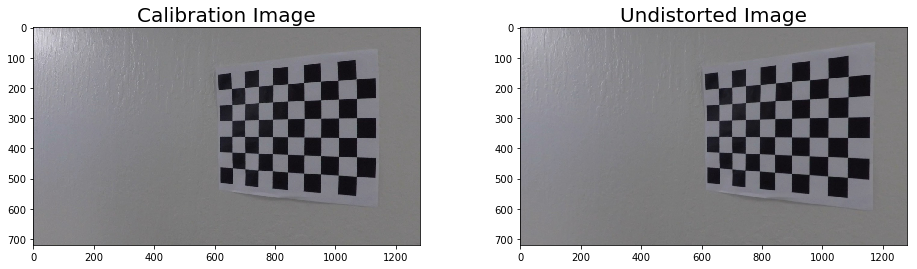

In [7]:
# # get a random image for calibration test
rand_cal_test = images_cal[np.random.randint(8)]

fig,(ax1,ax2) = plt.subplots(1, 2, figsize = (16,4))
ax1.imshow(rand_cal_test)
ax1.set_title('Calibration Image',fontsize=20)
ax2.imshow(undistort(rand_cal_test))
ax2.set_title('Undistorted Image',fontsize=20)

# ## free
# rand_cal_test = None

fig.savefig('./output_images/random_camera_calibration_test.png',bbox_inches='tight', pad_inches=0)

### P4 - Image Binarization

##### Method to convert a given images into a binary image

* Use color transforms, gradients, etc., to create a thresholded binary image.



This methods applies the following preprocessing algorithms in the specified order
> retrieve S-channel from HLS Space
>
> apply binary threshold on S-channel
>
> compute Sobel X filter on S-channel
>
> apply binary threshold on SobelX
>
> combine both the binary images from above
>
> retrive grayscale image and apply binary threshold
>
> compute bitwise AND between the combined binaries and grayscale binary
    

In [8]:
def binarizeImage(img, threshS=THRESH_SCHAN, threshSX=THRESH_SOBX, threshGray=THRESH_GRAY):
    """ Pipeline for applying image binarization
    
    This methods applies the following preprocessing algorithms in the specified order
    ** retrieve S -channel from HLS Space
    ** apply binary threshold on S -channel
    ** compute Sobel X filter on S -channel
    ** apply binary threshold on SobelX
    ** combine both the binary images from above
    ** retrive grayscale image and apply binary threshold
    ** compute bitwise AND between the combined binaries and grayscale binary
    """
    # pick color channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= threshS[0]) & (s_channel <= threshS[1])] = 1

    # apply Sobel filter with orientation on X-axis
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= threshSX[0]) & (scaled_sobel <= threshSX[1])] = 1

    combined_sobelx_color = np.zeros_like(sxbinary)
    combined_sobelx_color[(s_binary == 1) | (sxbinary == 1)] = 1

    ## binarize a grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    g_binary = np.zeros_like(gray)
    g_binary[(gray >= threshGray[0]) & (gray <= threshGray[1])] = 1

    color_binary = cv2.bitwise_and(combined_sobelx_color, g_binary)

    return color_binary

##### P4 - Test binarization method

*Picks up a randome image for further processing below*

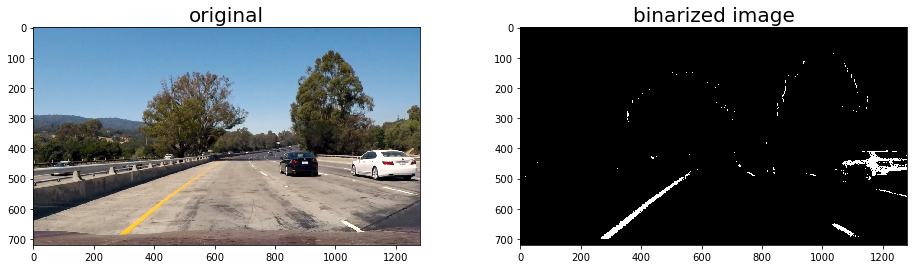

In [9]:
# ## procedure to test the above method. get a random test image and apply the above method
# # use this image in all the below cells for testing.
image = images[np.random.randint(6)]

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(image)
ax1.set_title('original',fontsize=20)

binary_image = binarizeImage(undistort(image))
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('binarized image',fontsize=20)

fig.savefig('./output_images/random_binarize_image_test.png',bbox_inches='tight', pad_inches=0)

### P4 - Perspective Transformation

* Apply a perspective transform to rectify binary image ("birds-eye view").


In [10]:
# gets an input image, and optional source and destination points
def perspectiveTransformation(img, src=PERSPECTIVE_SRC, dst=PERSPECTIVE_DST):
    """ Perform perpective tranformation for a given image
    
    """
    
    img_size = img.shape[:2]
    M     = cv2.getPerspectiveTransform(src, dst)
    M_INV = cv2.getPerspectiveTransform(dst, src)

    warped_img = cv2.warpPerspective(img, M, img_size[::-1], flags=cv2.INTER_LINEAR)

    return warped_img, M, M_INV

## P4 - Detect Lane Lines

* Detect lane pixels and fit to find the lane boundary.

### Image Processing Pipeline  ==> Code refactored to file lane_detection.py
##### Define methods used for the processing in the pipeline

In [11]:
# lanedetection.py --- radiusOfCurvature --- getVehiclePosition.

In [12]:
# lanedetection.py --- laneFitter 

#### Function to Draw Overlay

This function draws the final overlay on the image

In [13]:
# lanedetection.py --- drawOverlay 

##### This function combines the above methods and forms a pipeline

In [14]:
# This function will color lane on the image
# Input: Original image
# Output: Original image with colored region
def process_image_proj4(image, left_lane=LEFT_LANE, right_lane=RIGHT_LANE):
    # Apply pipeline to the image to create black and white image

    img = binarizeImage(undistort(image))
    
    # Warp the image to make lanes parallel to each other
    top_down, M, M_INV = perspectiveTransformation(img)

    # Find the lines fitting to left and right lanes
    # Set up lines for left and right
    yValues, leftFitX, rightFitX, lx, ly, rx, ry, curvature = laneFitter(top_down, left_lane, right_lane)
    
    # Return the original image with colored region
    return drawOverlay(image, top_down, yValues, leftFitX, rightFitX, lx, ly, rx, ry, M_INV, curvature)

##### Test the pipeline

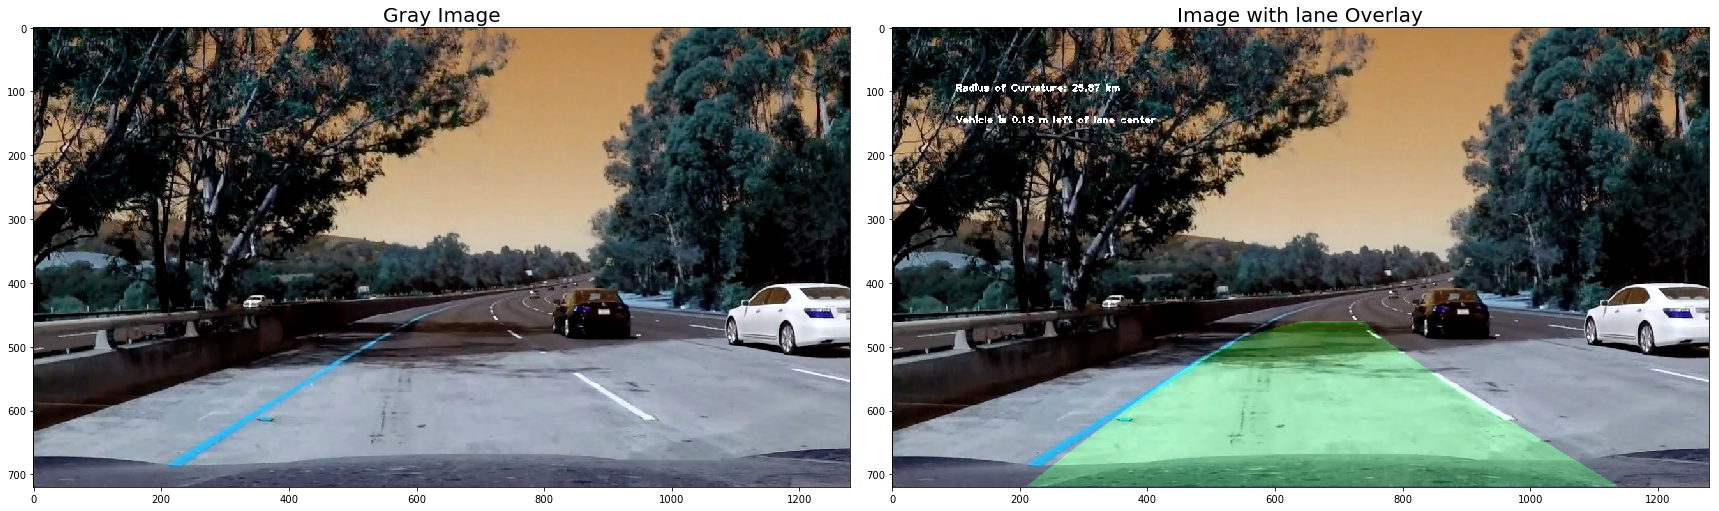

In [15]:
fname = 'test_images/test5.jpg'
img_raw = cv2.imread(fname)

left_lane = Line()
right_lane = Line()    

img = process_image_proj4(img_raw, left_lane, right_lane)

# Set up for the subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
# Showing the image from pipeline with marked areas
ax1.set_title('Gray Image', fontsize=20)
ax1.imshow(img_raw)

ax2.imshow(img)
ax2.set_title('Image with lane Overlay', fontsize=20)

f.savefig('./output_images/test_pipeline.png',bbox_inches='tight', pad_inches=0)

### P5 - Methods for Vehicle Detection

Project 5 - Vehicle Detection includes a majority of functions provided in the coursework. All methods from the coursework is included as a separate python file udacity_coursework.py

##### Define methods for Heatmap threshold & Draw boxes for detected vehicles

In [16]:
def heatThreshold(heatmap, threshold):
    """ Function to apply thresholds to heat map 
    
    """
    
    heatmap[heatmap <= threshold] = 0
    # Return the image after applying threshold
    return heatmap

def drawCarRect(img, labels, boxColor=None):
    """ Draw boxes around each identified car
    
    """
    
    if boxColor == None:
        ### Choose three different colors
        boxColor = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Iterate over all detected cars and draw a rectangle
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], boxColor[car_number%3-1], 2)
    return img

##### Feature Detection  & Classification

Methods for feature detection on the scaled training samples. The samples are normalized, scaled using both car images and non-car images. Augmented image samples are then used for training SVC classifier

In [17]:
# do feature extraction
def get_feature_set(car_samples=None, notcar_samples=None):
    
    
    if car_samples == None or notcar_samples == None:
        pass
        ## do pick random samples for training
        
    car_features = extract_features(car_samples, color_space, spatial_size, hist_bins, orient, pix_per_cell, \
                                    cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
    notcar_features = extract_features(notcar_samples, color_space, spatial_size, hist_bins, orient, pix_per_cell, \
                                       cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
   
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    return X_scaler, scaled_X, y

def get_trained_classifier(scaled_X, y, test=False):

    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.1, random_state = rand_state)
    
    # Use SVC
    svc = LinearSVC()
    svc.fit(X_train, y_train)

    if test:
        print('Test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc

#### Train Linear SVC Classifier

In [18]:

print ("Total no. of available car samples : ", len(cars))
print ("Total no. of available samples other than car : ", len(notcars))

# randomize input training data
randIndex = np.random.randint(0 , len(cars), 1000)

### get scaled input samples 
X_scaler, scaled_X, y = get_feature_set(np.array(cars)[randIndex], np.array(notcars)[randIndex])

SVC = get_trained_classifier(scaled_X, y, True)

Total no. of available car samples :  8792
Total no. of available samples other than car :  8968
Test accuracy of SVC =  0.99


In [19]:
def predictFeatures(img, svc=SVC, scale=SCALE, ystart=YSTART, ystop=YSTOP):
    
    window = 64
    cells_per_step = 2
    
    draw_img = np.copy(img)
    
    # heat map placeholder
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32) / 255
    
    framed_img = img[ystart:ystop,:,:]
    colorTxImg = convert_color(framed_img, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = colorTxImg.shape
        colorTxImg = cv2.resize(colorTxImg, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    channel1 = colorTxImg[:,:,0]
    channel2 = colorTxImg[:,:,1]
    channel3 = colorTxImg[:,:,2]
   
    # get number of boxes/steps to scan on the X-axis
    nxblocks = (channel1.shape[1] // pix_per_cell) - 1
    # get number of boxes/steps to scan on the Y-axis
    nyblocks = (channel1.shape[0] // pix_per_cell) - 1
        
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(channel1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(channel2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(channel3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    # step through different patch of images
    nfeat_per_block = orient * cell_per_block**2
    nblocks_per_window = (window // pix_per_cell) - 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    for x_step in range(nxsteps):
        for y_step in range(nysteps):
            
            ypos = y_step * cells_per_step
            xpos = x_step * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch   
            subimg = cv2.resize(colorTxImg[ytop:ytop + window, xleft:xleft + window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart),(0,0,255),6)
                # img_boxes.append(((xbox_left, ytop_draw +  ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] +=1
                
    return draw_img, heatmap

### Image processing pipeline for Project 5 (Vehicle Detection)

In [20]:
def process_image_proj5(img, svc=SVC, scale=SCALE, ystart=YSTART, ystop=YSTOP):
    
    out_img, heat_map = predictFeatures(img, svc, scale, ystart, ystop)
    heat_map = heatThreshold(heat_map, 0.5)
    
    # An array-like object to be labeled. 
    # Any non-zero values in input are counted as features and zero values are considered the background.
    labels = label(heat_map)
    draw_img = drawCarRect(np.copy(img), labels)
    
    return draw_img

In [21]:

test_output = 'project_output.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image_proj5)

test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [05:23<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 



### Image processing pipeline for Project 4 & 5 (Lane & Vehicle Detection)

In [22]:
def process_image_combined(image, svc=SVC, scale=SCALE, ystart=YSTART, ystop=YSTOP, left_lane=LEFT_LANE, right_lane=RIGHT_LANE):

    # Lane Detection
    img = binarizeImage(undistort(image))
    top_down, M, M_INV = perspectiveTransformation(img)
    yValues, leftFitX, rightFitX, lx, ly, rx, ry, curvature = laneFitter(top_down, left_lane, right_lane)
    
    # Vehicle Detection
    out_img, heat_map = predictFeatures(image, svc, scale, ystart, ystop)
    heat_map = heatThreshold(heat_map, 0.5)    
    labels = label(heat_map)
    draw_img = drawCarRect(np.copy(image), labels)
    
    return drawOverlay(draw_img, top_down, yValues, leftFitX, rightFitX, lx, ly, rx, ry, M_INV, curvature)

In [23]:

test_output = 'project_output_wLaneDetect.mp4'
clip = VideoFileClip("project_video.mp4")  # .subclip(28, 29)
test_clip = clip.fl_image(process_image_combined)

test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output_wLaneDetect.mp4
[MoviePy] Writing video project_output_wLaneDetect.mp4


100%|█████████▉| 1260/1261 [11:42<00:00,  1.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_wLaneDetect.mp4 



#### Test Feature Prediction & Obtain Heatmap

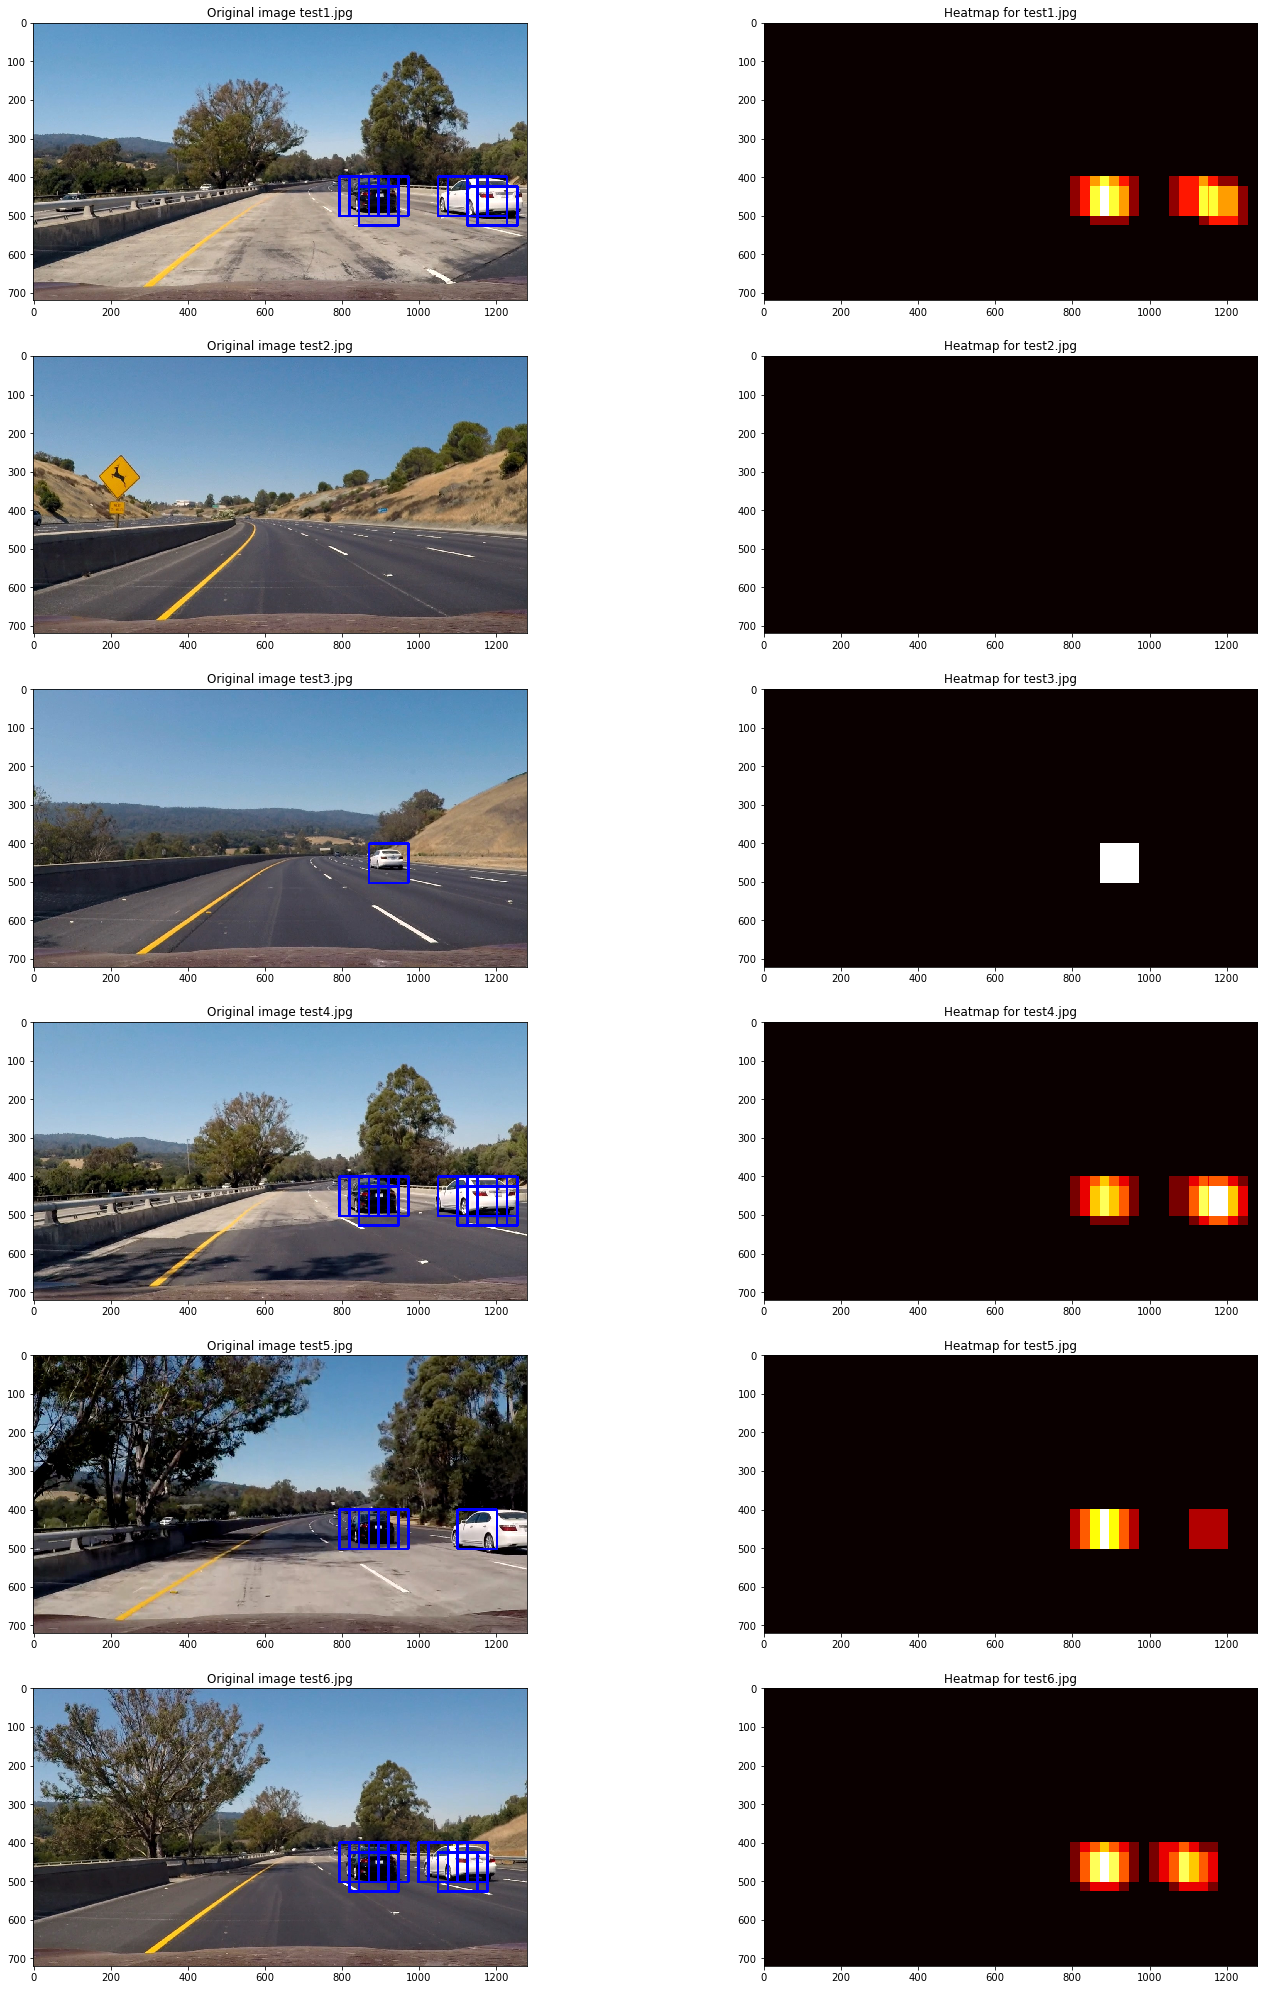

In [24]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)

ret_images = []
ret_titles = []

for img_src in example_images:
    img_boxes = []
    count = 0
    img = mpimg.imread(img_src)
    
    draw_img, heatmap = predictFeatures(img)

    ret_images.append(draw_img)
    ret_titles.append('Original image ' + img_src.split('/')[1])

    ret_images.append(heatmap)
    ret_titles.append('Heatmap for ' + img_src.split('/')[1])    

fig = plt.figure(figsize = (24, 48))
visualize(fig, 8, 2, ret_images, ret_titles)  

fig.savefig('./output_images/boxes_heatmaps.png',bbox_inches='tight', pad_inches=0)

##### Process the input video using the above pipeline and store

In [25]:

# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

# # Set up lines for left and right
# left_lane = Line()
# right_lane = Line()
# white_output = 'output_project_video.mp4'

# clip1 = VideoFileClip("project_video.mp4")
# white_clip = clip1.fl_image(process_image)
# %time white_clip.write_videofile(white_output, audio=False)

### HOG Playground

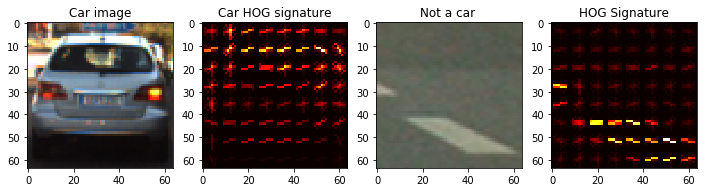

In [26]:

# Read in a car and non car image
car_image = mpimg.imread(cars[4070])
notcar_image = mpimg.imread(notcars[7667])


orient = 7
hist_bins = 32
hog_channel = 0
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)

hog_feat = True
hist_feat = True
spatial_feat = True

color_space = 'LUV'


car_features, car_hog_image = single_img_features(car_image,
                                                  color_space = color_space,
                                                  spatial_size = spatial_size,
                                                  hist_bins = hist_bins,
                                                  orient = orient,
                                                  pix_per_cell = pix_per_cell,
                                                  cell_per_block = cell_per_block,
                                                  hog_channel = hog_channel,
                                                  spatial_feat = spatial_feat,
                                                  hist_feat = hist_feat,
                                                  hog_feat = hog_feat,
                                                  vis = True
                                                 )

notcar_features, notcar_hog_image = single_img_features(notcar_image,
                                                  color_space = color_space,
                                                  spatial_size = spatial_size,
                                                  hist_bins = hist_bins,
                                                  orient = orient,
                                                  pix_per_cell = pix_per_cell,
                                                  cell_per_block = cell_per_block,
                                                  hog_channel = hog_channel,
                                                  spatial_feat = spatial_feat,
                                                  hist_feat = hist_feat,
                                                  hog_feat = hog_feat,
                                                  vis = True
                                                 )
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['Car image', 'Car HOG signature', 'Not a car ', 'HOG Signature']
fig = plt.figure(figsize=(12,3)) 
visualize(fig, 1, 4, images, titles)


### Test Pipeline

In [27]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)

ret_images = []
ret_titles = []

for img_src in example_images:
    img_boxes = []
    count = 0
    img = mpimg.imread(img_src)
    
    draw_img = process_image_proj5(img, SVC, SCALE, YSTART, YSTOP)

    ret_images.append(img)
    ret_titles.append('Original image ' + img_src.split('/')[1])

    ret_images.append(draw_img)
    ret_titles.append('Processed image ' + img_src.split('/')[1])

fig = plt.figure(figsize = (24, 48))
visualize(fig, len(example_images), 1, ret_images, ret_titles)  

fig.savefig('./output_images/pipeline_test.png', bbox_inches='tight', pad_inches=0)

ValueError: operands could not be broadcast together with shapes (1,7284) (6108,) (1,7284) 